In [1]:
## load an image dataset using tf.data.
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
tf.__version__

'2.2.0-dev20200501'

In [2]:
# Retrieve the images
# use an archive of creative-commons licensed flower photos from Google.

import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 83s 0us/step


In [9]:
# The directory contains 5 sub-directories, one per class:  
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

3670

In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

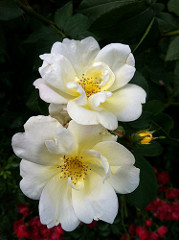

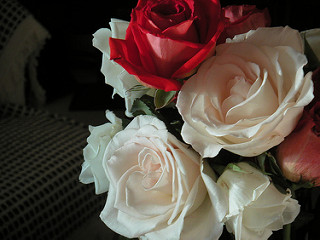

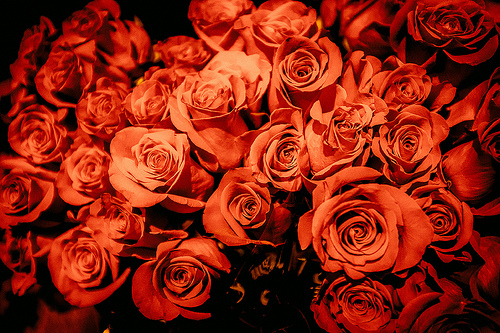

In [11]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [12]:
# Load using keras.preprocessing
# A simple way to load images is to use tf.keras.preprocessing.
    # The above keras.preprocessing method is convienient, but has three downsides:
    # It's slow. See the performance section below.
    # It lacks fine-grained control.
    # It is not well integrated with the rest of TensorFlow.
     
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [13]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [17]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [18]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

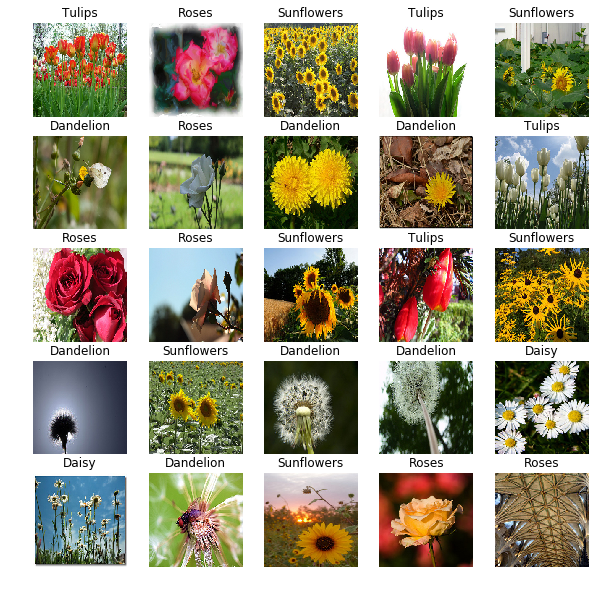

In [19]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [20]:
# Load using tf.data
# To load the files as a tf.data.Dataset first create a dataset of the file paths:

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
  print(f.numpy())


b'C:\\Users\\Nano\\.keras\\datasets\\flower_photos\\tulips\\7179796338_05e8b1c87b.jpg'
b'C:\\Users\\Nano\\.keras\\datasets\\flower_photos\\daisy\\54377391_15648e8d18.jpg'
b'C:\\Users\\Nano\\.keras\\datasets\\flower_photos\\sunflowers\\3897174387_07aac6bf5f_n.jpg'
b'C:\\Users\\Nano\\.keras\\datasets\\flower_photos\\tulips\\3501996215_1c6d1a3386_n.jpg'
b'C:\\Users\\Nano\\.keras\\datasets\\flower_photos\\tulips\\3558517884_0c7ca8b862_m.jpg'


In [21]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [22]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [23]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


In [28]:
# Basic methods for training
# tf.data api. : features can be easily added 

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


In [29]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

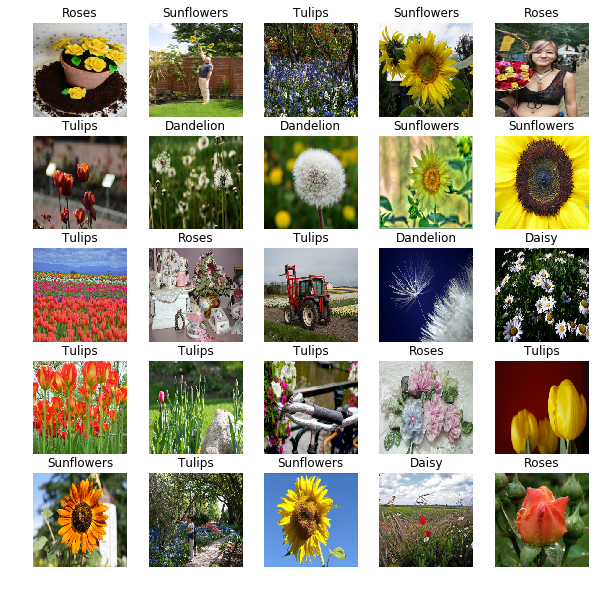

In [30]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [31]:
# Performance
# To investigate, first here's a function to check the performance of our datasets:
 
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [32]:
# Let's compare the speed of the two data generators:

# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 128.92661213874817 s
248.20322 Images/s


In [33]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 12.00412130355835 s
2665.75114 Images/s


In [34]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds) 

....................................................................................................
1000 batches: 44.21539306640625 s
723.72985 Images/s


In [35]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 42.3805570602417 s
755.06322 Images/s
